In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Volcano\\quail_volcano\\scenarios\\entrainment\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [3]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

from types import SimpleNamespace

os.chdir(target_dir)

In [4]:
# Default physics backend construction
wlma = mixtureWLMA.WLMA(c_v_m0=1e3)

# Manual import of water methods
import sys
sys.path.append(r"C:\Volcano\quail_volcano\src\physics\multiphaseWLMA\iapws95_light")
import float_mix_functions

import scipy.optimize
import scipy.integrate

### 0D experiment: adiabatic expansion work potential

Consider isobaric mixing of water, at a 2.5 MPa overpressure, and the work generated by mixture-isentropic expansion


In [5]:
wlma.rho_m0, wlma.c_v_m0

(2600.0, 1000.0)

First: Consistency check: rel pressure difference from manual vs native calculation
Second: Consistency check: temperature difference from native calculation vs. input
Third: Consistency check: calculated rhow


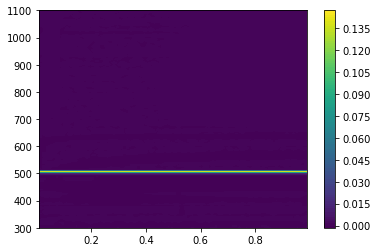

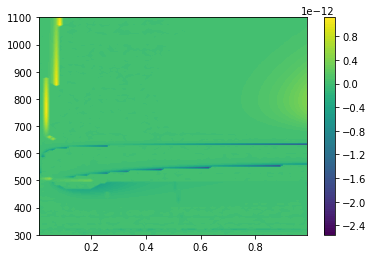

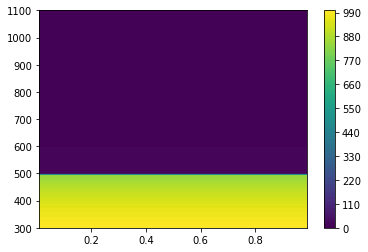

In [8]:
yw_vec = np.linspace(1e-2, 1-1e-2-1e-6, 80)#90)
T_vec = np.linspace(300, 1100, 121)#51)
ya = 1e-6
p_end = 1e5
p_start = 1e5 + 2.5e6 # 2.5e6

mg_yw, mg_T = np.meshgrid(yw_vec, T_vec)
mg_rhow = mg_T.copy()
mg_p = mg_T.copy()
mg_T_check = mg_T.copy()
mg_rhomix = mg_T.copy()
mg_vol_energy = mg_T.copy()

rhow_init_guesses = [998, 15, 50, 200, 400, 800, 1000, *np.linspace(10,996,300)]

for i, yw in enumerate(mg_yw.ravel()):
  T = mg_T.ravel()[i]

  # Use list of reasonable initial guesses to find rhow matching desired start pressure
  for guess in rhow_init_guesses:
    fsolve_out = scipy.optimize.fsolve(lambda rhow: (float_mix_functions.p(rhow, T) - p_start)/p_start,
                          guess, full_output=True)
    if fsolve_out[2] == 1:
      break
  else:
    print(f"Did not find satisfactory solution for T = {T}, yw = {yw}.")   

  # Conservative-inconsistent rhow, p
  rhow = float(fsolve_out[0])
  p_target = float_mix_functions.p(rhow, T)

  rhom = wlma.rho_m0 * (1 + (p_target - wlma.p_m0) / wlma.K)
  rhoa = p_target / (wlma.R_a * T)
  yw = mg_yw.ravel()[i]
  ym = 1 - ya - yw
  rho_mix = 1 / (yw / rhow + ym / rhom + ya / rhoa)
  ea = wlma.R_a / (wlma.gamma_a - 1.0) * T
  ew = float_mix_functions.u(rhow, T)
  em = wlma.c_v_m0 * T + float_mix_functions.magma_mech_energy(p_target, wlma.K, wlma.p_m0, wlma.rho_m0)
  vol_energy = rho_mix * (yw * ew + ym * em + ya * ea)

  wlma_params_placeholder = dict(vol_energy=vol_energy,
    rho_mix=rho_mix,
    yw=yw,
    ya=ya,
    K=wlma.K,
    p_m0=wlma.p_m0,
    rho_m0=wlma.rho_m0,
    c_v_m0=wlma.c_v_m0,
    R_a=wlma.R_a,
    gamma_a=wlma.gamma_a,
  )

  # Conservative-consistent rhow, p (rhow, p, T, c, volfracW)
  rhow, p, T, c, volfracW = wlma.WLM_rhopT_native(
    rho_mix * np.array([[ya, yw, 1-(yw+ya)]]),
    np.array([[0]]),
    np.array([[vol_energy]]), None)
  
  mg_rhomix.ravel()[i] = rho_mix
  mg_vol_energy.ravel()[i] = vol_energy
  mg_rhow.ravel()[i] = rhow
  mg_p.ravel()[i] = p
  mg_T_check.ravel()[i] = T

plt.contourf(mg_yw, mg_T, mg_p / p_start - 1, levels=100)
plt.colorbar()
print("First: Consistency check: rel pressure difference from manual vs native calculation")

plt.figure()
plt.contourf(mg_yw, mg_T, (mg_T_check - mg_T) / mg_T_check, levels=100)
print("Second: Consistency check: temperature difference from native calculation vs. input")
plt.colorbar()

plt.figure()
plt.contourf(mg_yw, mg_T, mg_rhow, levels=100)
plt.colorbar()
print("Third: Consistency check: calculated rhow")


In [ ]:
# Run adiabatic expansion ODE for each point on map

ya = 1e-7

mg_p_final = mg_p.copy()
mg_T_final = mg_p.copy()
mg_volfracW_final = mg_p.copy()
mg_e_initial = mg_p.copy()
mg_e_final = mg_p.copy()
mg_rhow_final = mg_p.copy()

N = mg_yw.ravel().size

for i, yw in enumerate(mg_yw.ravel()):
  rhow = mg_rhow.ravel()[i]
  p = mg_p.ravel()[i]
  T = mg_T.ravel()[i]
  
  rhom = wlma.rho_m0 * (1 + (p - wlma.p_m0) / wlma.K)
  rhoa = p / (wlma.R_a * T)
  yw = mg_yw.ravel()[i]
  ym = 1 - ya - yw
  rho_mix = mg_rhomix.ravel()[i]
  # rho_mix = 1 / (yw / rhow + ym / rhom + ya / rhoa)
  ea = wlma.R_a / (wlma.gamma_a - 1.0) * T
  ew = float_mix_functions.u(rhow, T)
  em = wlma.c_v_m0 * T + float_mix_functions.magma_mech_energy(p, wlma.K, wlma.p_m0, wlma.rho_m0)
  vol_energy = mg_vol_energy.ravel()[i]
  # vol_energy = rho_mix * (yw * ew + ym * em + ya * ea)
  spec_energy = vol_energy / rho_mix
  mg_e_initial.ravel()[i] = spec_energy

  wlma_params_placeholder = dict(vol_energy=vol_energy,
    rho_mix=rho_mix,
    yw=yw,
    ya=ya,
    K=wlma.K,
    p_m0=wlma.p_m0,
    rho_m0=wlma.rho_m0,
    c_v_m0=wlma.c_v_m0,
    R_a=wlma.R_a,
    gamma_a=wlma.gamma_a,
  )

  # ODE setup
  # Isentropic
  # de = p/(rho)^2 d(rho)
  # with ending event p == p_end

  def RHS(rho_mix, e):
    ''' Independent rho_mix, dependent variable e '''
    # print(rho_mix, e)
    rho_mix = float(rho_mix)
    e = float(e)
    p = float(wlma.WLM_rhopT_native(np.array([[ya*rho_mix, yw*rho_mix, ym*rho_mix]]),
              np.array([[0]]),
              np.array([[rho_mix * e]]), None)[1])
    de = p / (rho_mix * rho_mix)
    return [de]

  if i % 500 == 0:
    print(f"Iter {i}/{N} done")

  def term_event(rho_mix, e):
    rho_mix = float(rho_mix)
    e = float(np.array(e))
    p = float(wlma.WLM_rhopT_native(np.array([[ya*rho_mix, yw*rho_mix, ym*rho_mix]]),
              np.array([[0]]),
              np.array([[rho_mix * e]]), None)[1])
    return p / p_end - 1.0

  term_event.direction = -1
  term_event.terminal = True

  soln = scipy.integrate.solve_ivp(RHS, [rho_mix, 0.000001], [spec_energy], events=term_event)

  rho_mix = soln.t[-1]
  spec_energy = soln.y.squeeze()[-1]
  rhow, p, T, c_hist, volfracW = wlma.WLM_rhopT_native(
    np.array([[ya*rho_mix, yw*rho_mix, ym*rho_mix]]),
              np.array([[0]]),
              np.array([[rho_mix * spec_energy]]), None)

  # Save adiabatic expansion calculations
  mg_p_final.ravel()[i] = float(p)
  mg_T_final.ravel()[i] = float(T)
  mg_rhow_final.ravel()[i] = float(rhow)
  mg_volfracW_final.ravel()[i] = float(volfracW)
  mg_e_final.ravel()[i] = spec_energy

mg_work = mg_e_initial - mg_e_final

plt.contourf(mg_yw, mg_T, mg_p_final, levels=100)
print("Check final pressure = target end pressure within 10%")
print(f"Min: {mg_p_final.min()}, max: mg_p_final.max()")

Iter 0/9680 done
Iter 500/9680 done
Iter 1000/9680 done


Text(0.5, 1.0, 'FUTURE: sound speed mismatch between isentropic stepping and thermodynamic c^2')

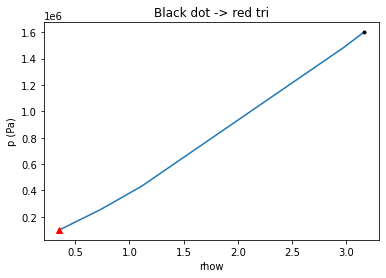

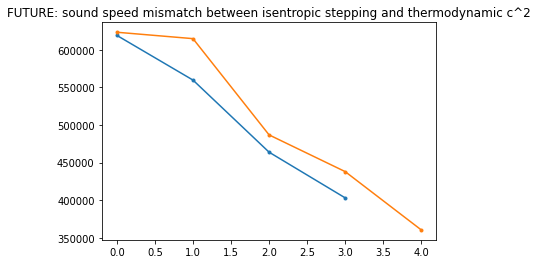

In [ ]:

rhow_hist, p_hist, T_hist, c_hist, volfracW_hist = zip(*[wlma.WLM_rhopT_native(np.array([[ya*t, yw*t, ym*t]]),
            np.array([[0]]),
            np.array([[t * y]]), None) for (t, y) in zip(soln.t, soln.y.ravel())])
rhow_hist = np.array(rhow_hist).squeeze()
p_hist = np.array(p_hist).squeeze()
T_hist = np.array(T_hist).squeeze()
c_hist = np.array(c_hist).squeeze()
volfracW_hist = np.array(volfracW_hist).squeeze()

rho_mix_hist = soln.t
e_hist = soln.y.ravel()

# plt.plot(rho_mix_hist, p_hist, '.-')
plt.figure()
plt.plot(rhow_hist, p_hist)
plt.plot(rhow_hist[0], p_hist[0], 'k.')
plt.plot(rhow_hist[-1], p_hist[-1], 'r^')
plt.xlabel("rhow")
plt.ylabel("p (Pa)")
plt.title("Black dot -> red tri")

plt.figure()
plt.plot(np.diff(p_hist)/np.diff(rho_mix_hist), '.-')
plt.plot(c_hist * c_hist, '.-')
p_hist[-1]
plt.title("FUTURE: sound speed mismatch between isentropic stepping and thermodynamic c^2")

In [ ]:
def default_plot(mg_yw, mg_T, mg_z, *args, **kwargs):
  # Extend interior values to the margins (assuming limiting value is similar)
  mg_yw_loc = np.concatenate((
    mg_yw[:,0:1] - (mg_yw[:,1:2] - mg_yw[:,0:1]),
    mg_yw,
    mg_yw[:,-1:] + (mg_yw[:,-1:] - mg_yw[:,-2:-1]),), axis=-1)
  mg_T_loc = np.concatenate((
    mg_T[:,0:1],
    mg_T,
    mg_T[:,-1:]), axis=-1)
  mg_z_loc = np.concatenate((
    mg_z[:,0:1],
    mg_z,
    mg_z[:,-1:]), axis=-1)
  cf = plt.contourf(1e2 * mg_yw_loc, mg_T_loc - 273.15, mg_z_loc, *args, **kwargs)
  plt.gca().set_xlim(0, 100)
  plt.gca().set_xticks(np.linspace(0,100,6))
  

  global_fontsize = 14
  ax = plt.gca()
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(global_fontsize)
  plt.xlabel("wt% water", fontsize=16)
  plt.ylabel("Temperature (${}^\circ$C)", fontsize=16)
  return cf

def contour_overlay(mg_yw, mg_T, mg_z, *args, **kwargs):
  # Extend interior values to the margins (assuming limiting value is similar)
  mg_yw_loc = np.concatenate((
    mg_yw[:,0:1] - (mg_yw[:,1:2] - mg_yw[:,0:1]),
    mg_yw,
    mg_yw[:,-1:] + (mg_yw[:,-1:] - mg_yw[:,-2:-1]),), axis=-1)
  mg_T_loc = np.concatenate((
    mg_T[:,0:1],
    mg_T,
    mg_T[:,-1:]), axis=-1)
  mg_z_loc = np.concatenate((
    mg_z[:,0:1],
    mg_z,
    mg_z[:,-1:]), axis=-1)
  cont = plt.contour(1e2 * mg_yw_loc, mg_T_loc - 273.15, mg_z_loc, *args, **kwargs)
  return cont

Text(0.5, 1.0, 'Final temperature minus atmospheric boiling')

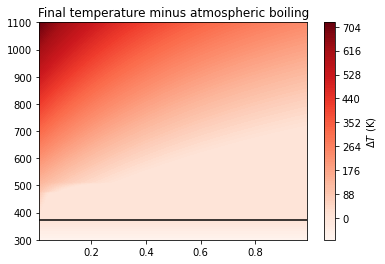

In [ ]:
# Compute atmospheric boiling line
sat_T_vec = np.linspace(300, 647.096, 1000)
sat_p_vec = [float_mix_functions.prho_sat(T)["psat"] for T in sat_T_vec]
# plt.plot(sat_T_vec, sat_p_vec)
# plt.xlabel("T (K)")
# plt.ylabel("p_{sat} (Pa)")
# Compute atmospheric boiling temperature (scalar)
T_boil_atm = np.interp(p_end, sat_p_vec, sat_T_vec)
T_boil_start = np.interp(p_start, sat_p_vec, sat_T_vec)

plt.figure()
plt.contourf(mg_yw, mg_T, mg_T_final-T_boil_atm, levels=100)
cb = plt.colorbar()
plt.contour(mg_yw, mg_T, mg_T_final-T_boil_atm, levels=[0], colors=["black"])
cb.set_label("$\Delta T$ (K)")
plt.title("Final temperature minus atmospheric boiling")

Water density plot: indicates initially liquid vs vapor water
Work per mass; higher for high-energy compressed water vapor


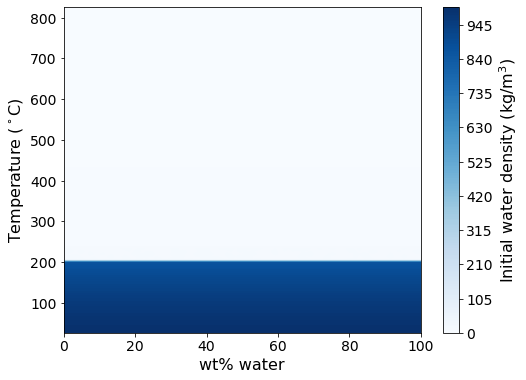

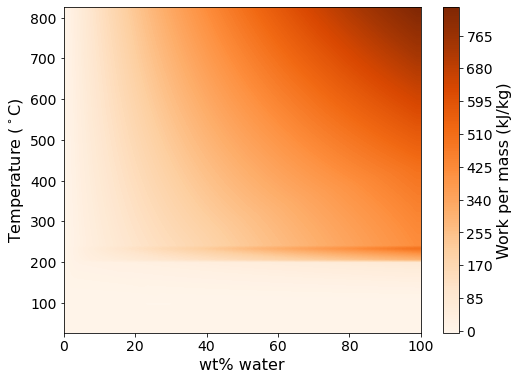

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.set_cmap("Blues")
cf = default_plot(mg_yw, mg_T, mg_rhow, levels=200)
cb = plt.colorbar(label="Initial water density (kg/m${}^3$)")
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.tick_params(labelsize=14)
# cb.ax.set_ticks([5, 305, 605, 905])
print("Water density plot: indicates initially liquid vs vapor water")
plt.savefig(f"InitialDensity_{int(p_start/1e3)}kPa.png", dpi=400)

fig = plt.figure(figsize=(8,6))
plt.set_cmap("Oranges")
cf = default_plot(mg_yw, mg_T, mg_work/1e3, levels=200)
cb = plt.colorbar(label="Work per mass (kJ/kg)")
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.tick_params(labelsize=14)
# cb.ax.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8])
print("Work per mass; higher for high-energy compressed water vapor")
plt.savefig(f"Work_{int(p_start/1e3)}kPa.png", dpi=400)


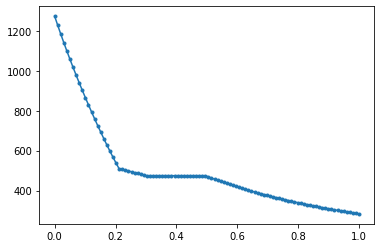

In [ ]:
# Curve for 1000 C magma + 10 C water
# Conserving energy, isobaric mixing
# (p = p_start, E = y_m * e_m + y_w * e_w)

T_m = 1273.15
T_w = 10 + 273.15

def rhow_p(p_start, T):
  rhow_init_guesses = [998, 15, 50, 200, 400, 800, 1000, *np.linspace(10,996,300)]
  for guess in rhow_init_guesses:
    fsolve_out = scipy.optimize.fsolve(lambda rhow: (float_mix_functions.p(rhow, T) - p_start)/p_start,
                          guess, full_output=True)
    if fsolve_out[2] == 1:
      break
  else:
    print("No satisfactory rhow found.")
  return fsolve_out[0]

def T_isenthalpic_equilibrium(ym, yw, T_m, T_w, p_start):

  # # Initial magma enthalpy
  e_m = wlma.c_v_m0 * T_m
  rho_m = wlma.rho_m0 * (1 + (p_start - wlma.p_m0) / wlma.K)
  h_m = e_m + p_start / rho_m
  # # Initial water enthalpy
  rhow = float_mix_functions.rho_l_pt(p_start, T_w)
  h_w = float_mix_functions.u(rhow, T_w) + p_start / rhow
  # # Isenthalpic mixing
  h_mix0 = ym * h_m + yw * h_w

  # Solve for isenthalpic equilibrium temperature
  def h_mix(T, ym, yw):
    
    rhow = rhow_p(p_start, T)

    return (ym * (wlma.c_v_m0 * T
                  + p_start / rhom)
            + yw * (float_mix_functions.u(rhow, T) + p_start / rhow))

  soln = scipy.optimize.brenth(lambda T: h_mix(T, ym, yw) / h_mix0 - 1.0, T_w, T_m, full_output=True)
  if not soln[1]: # if not converged
    print(soln)
  return soln[0]

yw_sample = np.linspace(1e-4, 1-1e-4, 100)
T_mixing_curve = [T_isenthalpic_equilibrium(1-yw, yw, T_m, T_w, p_start) for yw in yw_sample]
plt.plot(yw_sample, T_mixing_curve, '.-')

Text(0.5, 1.0, 'Relative error in h (given any solution rhow satisfying p = p_start)')

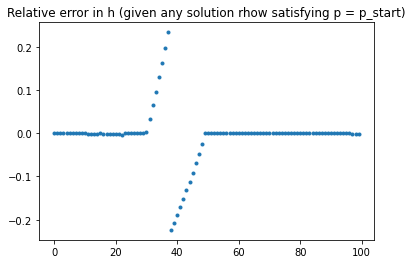

In [ ]:


rel_h_error = np.zeros_like(yw_sample)
for i in range(len(yw_sample)):
  _T = T_mixing_curve[i]
  _yw = yw_sample[i]
  _rhow = rhow_p(p_start, _T)
  _rhom = wlma.rho_m0 * (1 + (p_start - wlma.p_m0) / wlma.K)

  _hm = (wlma.c_v_m0 * _T + p_start / _rhom)
  _hw = float_mix_functions.u(_rhow, _T) + p_start / _rhow
  _h_T = (1 - _yw) * _hm + _yw * _hw
  _rhow0 = float_mix_functions.rho_l_pt(p_start, T_w)
  _h0 = (1 - _yw) * (wlma.c_v_m0 * T_m + p_start / _rhom) + _yw * (float_mix_functions.u(_rhow, T_w) + p_start / _rhow0)

  rel_h_error[i] = _h_T / _h0 - 1.0
plt.plot(rel_h_error, '.')
plt.title("Relative error in h (given any solution rhow satisfying p = p_start)")

Work per mass; higher for high-energy compressed water vapor


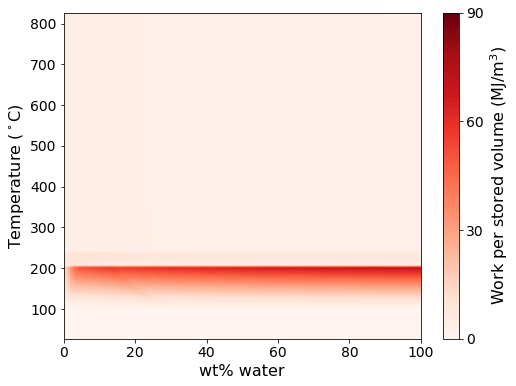

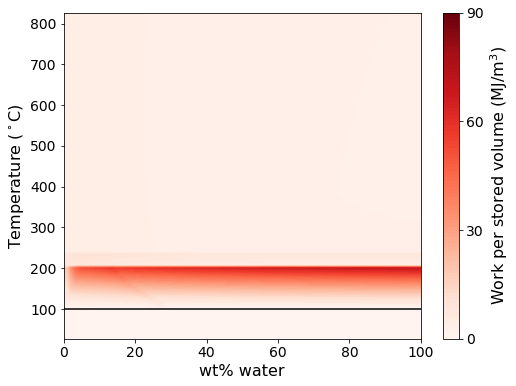

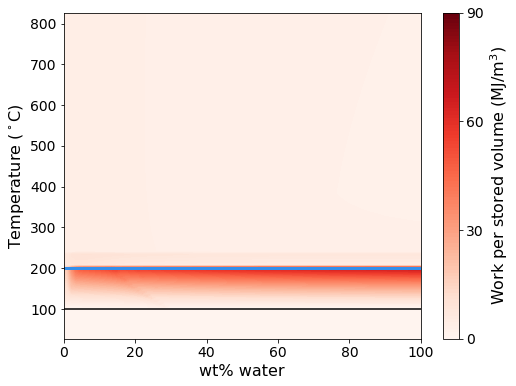

In [ ]:
fig = plt.figure(figsize=(8,6))

def plot_base():
  plt.set_cmap("Reds")
  cf = default_plot(mg_yw, mg_T, np.clip(mg_rhomix * mg_work/1e6, 0, None), levels=np.linspace(0,90,100))
  cb = plt.colorbar(label="Work per stored volume (MJ/m${}^3$)")
  cb.set_ticks([0.0, 30, 60, 90])
  cb.ax.yaxis.label.set_fontsize(16)
  cb.ax.tick_params(labelsize=14)
  return cf, cb
cf, cb = plot_base()
plt.savefig(f"WorkVol_{int(p_start/1e3)}kPa_1.png", dpi=400)


fig = plt.figure(figsize=(8,6))
cf, cb = plot_base()
contour_overlay(mg_yw, mg_T, mg_T-T_boil_start, levels=[0], colors=["#348feb"], linewidths=3)
plt.savefig(f"WorkVol_{int(p_start/1e3)}kPa_2.png", dpi=400)

fig = plt.figure(figsize=(8,6))
cf, cb = plot_base()
contour_overlay(mg_yw, mg_T, mg_T-T_boil_start, levels=[0], colors=["#348feb"], linewidths=3)
contour_overlay(mg_yw, mg_T, mg_T_final-T_boil_atm, levels=[0], colors=["black"])
plt.savefig(f"WorkVol_{int(p_start/1e3)}kPa_3.png", dpi=400)

print("Work per mass; higher for high-energy compressed water vapor")

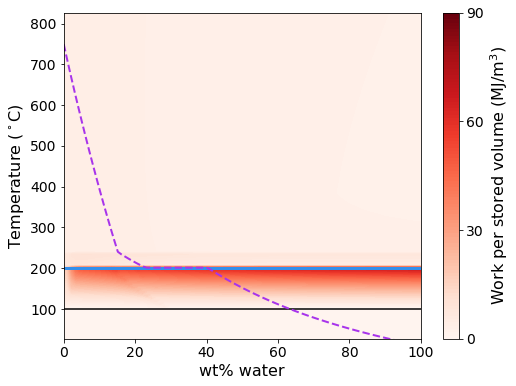

In [ ]:
fig = plt.figure(figsize=(8,6))
cf, cb = plot_base()
contour_overlay(mg_yw, mg_T, mg_T_final-T_boil_atm, levels=[0], colors=["black"])
contour_overlay(mg_yw, mg_T, mg_T-T_boil_start, levels=[0], colors=["#348feb"], linewidths=3)
yw_sample = np.linspace(1e-4, 1-1e-4, 100)
T_mixing_curve = np.array([T_isenthalpic_equilibrium(1-yw, yw, 750+273.15, 10+273.15, p_start) for yw in yw_sample])
plt.plot(100*yw_sample, T_mixing_curve-273.15, '--', color="#a834eb", linewidth=2)
plt.ylim(bottom = mg_T.min()-273.15)

plt.savefig(f"WorkVol_{int(p_start/1e3)}kPa_4.png", dpi=400)
